# this code is analysis of experiment using code built with positive control data
[I used simulation data for two systems. In both the Smad pathway is simulated identically, with random noise in parameters and protein expression. The differene in the two systems is that in system 1, [gene = f(Smad3/4)], target gene expression depends directly on nuclear Smad3/Smad4, and in system 2, [gene = f(Smad3/4 , X)] target gene expression depends on nuclear Smad3/Smad4 and a randomly varying other factor, X (which in this case is a factor that affects how strongly Smad3/4 induces gene expression.]

From the simulated data, I use full trajectories for the level nuclear Smad3--that is the concentration of all species of Smad3 in the nucleus, such as would be observed in a microscope. (Note, I am not using trajectories for Smad3/Smad4 complex, which is the actual molecular complex on which gene production depends. I do not use these trajectories because they are not measurable in cells). Second, I use full trajectories of target gene production. For gene expression I analyze either A) a gene whose production depends directly on Smad3/Smad4 binding, or B) a gene whose production depends on a small network motif (3-nodes total, I-FFL1 specifically) that causes production of gene to be proportional to the fold-change in Smad3/Smad4 complex.

For experimental""" analysis, I take trajectories of nuclear NG-Smad3, which were measured in single cells from experiments and I take trajectories of total nuclear Snail:mCherry (or median, see next experiment). I first run diffusion maps on the NG-Smad3 trajectories to obtain a good DMAP for NG-Smad3. Then I obtain a DMAP for Snail using the same method. Then I use Gaussian Process Regression to assess whether Snail dynamics (i.e. Snail DMAP) can be predicted using Smad3 dynamics (i.e. Snail DMAP). 

In order to obtain a good diffusion map, I prepare (process?) the original data in the following way.
1. First, I take raw data as is. This is matrix1. (Matrix1 is M cells X N timepoints)
2. Then I take the raw data and compute the derivative of each trajectory. This is matrix 2. 
3. Then I take the raw data and compute the integral of each trajectory. This is matrix 3. 
4. Then I combine matrices 1, 2 and 3 into one new matrix, MatrixCAT (MatrixCAT is M cells X 3*N timepoints)
5. Then I transform this data set (in a way the preserves the topology of the data set) by normalizing all trajectories at each time point using the following:
    MT = MatrixCAT[t,:] (t=1)
    [MT is an 1 x M array, where M is the number of cells]
    MTn = MT-min(MT)/(max(MT)-min(MT)
    MTns = sqrt(MTn)
    MatrixCATztos[t,:] = MTns
    [I do this for all timepoints]
6. This transformation preserves topology, and it ensures that the difussion distances are similar for each dimension, which is important for finding a good difussion kernel for the diffusion map algoritm. 
7. By including raw data, first derivative of data, and integral of data were are enableing the algorithm to find a difussion Map that uncovers the dynamical features of the data set. 





In [1]:
# import time
# start = time.time()
# for x in range (0,5): 
#     print('',end="\r")
#     b = "Loading" + "." * x
#     print (b, end="")
    
# print('')
# end = time.time()
# print(end - start)

In [2]:
import time


# below this is the one value you must change if you change how this code runs

In [3]:
#epscale paramters
#num_evecs
#peakfindercutoff

#epsilon search parameters
num_eps = 50
eL = 1.2
eH = 4

evecs_cut = True
num_evecs=30

sampiter = 20 #number of times to iterate through Local linear regression
subsampfactor = 8 #scale at which to subsample data for LLR # subsampsize = np.ceil(datasize/subsampfactor)
subsampmax = 500 # never run LLR for more than 500 data pts; it will fail

reducedimval = 50
promval = 0.05 #defines prominence of peaks at which to threshold

# specid = 'EXP_S3conc_SNAILconc_gpy_LLRpeakfinder-AGNOSTIC-ztosqrtResample'
specid = 'agnostic-AGI-zto_numeps'+str(num_eps)+'-'+str(eL)+'-'+str(eH)+'_rdimval'+str(reducedimval)+'_n-evecs'+str(num_evecs)+'cut-'+str(evecs_cut)+'_promval-'+str(promval)+'_SI-'+str(sampiter)+'_subsampF'+str(subsampfactor)+'_sampmax'+str(subsampmax)  
print(specid)

#SESSIONNAME this needs all of the above information
#this is for saving the pickle file


# conditionid = 'exp3'     #exp3, exp4, expSYST1_PC, expSYST2_PC, expSYST3_PC
# complex_rsmad_SMADtot_SMADmed = 'median'     #median, total, complex, rsmad
# iffl_caga_SNAtot_SNAmed = 'median'   #median, total, iffl, caga

agnostic-AGI-zto_numeps50-1.2-4_rdimval50_n-evecs30cut-True_promval-0.05_SI-20_subsampF8_sampmax500


/Users/frick/Dparams/DParamsFinal_v5
12  runs to perform
----- expSYST1_PC - rsmad - iffl


 /Users/frick/anaconda/lib/python3.6/site-packages/matplotlib/text.py:1191: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


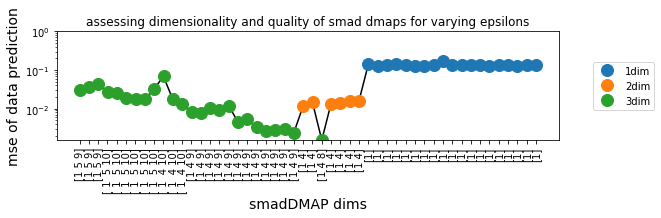

 /Users/frick/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:1479: UserWarning:Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


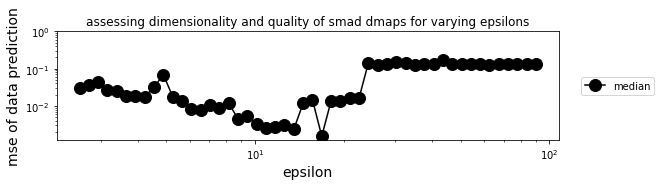

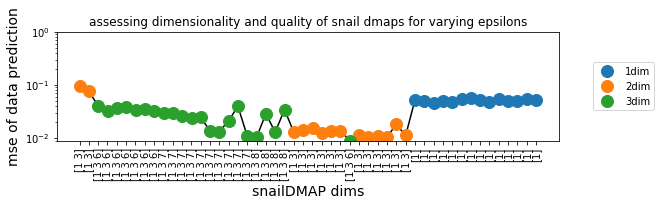

KeyboardInterrupt: 

In [57]:
from pathlib import Path
cwd = Path().resolve()
print(cwd)
import sys
sys.path.insert(0, cwd) 


import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as manimation
import numpy as np

import matplotlib.tri as mtri

from scipy.integrate import odeint
from scipy.integrate import complex_ode

import scipy.spatial.distance
import scipy
import scipy.interpolate
import scipy.signal
import itertools 
import re

from dmap_sp_chrisNEW import *
import os

import dmap_sp_chrisNEW
import importlib
importlib.reload(dmap_sp_chrisNEW)
    
from accessory import *

a = ['exp3','exp4']
b = ['median','total']
c = ['median','total']
d1 = list(itertools.product(a, b, c))

a = ['expSYST1_PC','expSYST2_PC','expSYST3_PC']
b = ['rsmad','complex']
c = ['iffl','caga']
d2 = list(itertools.product(a, b, c))


dall = d1+d2
dall = d2
print(len(dall), ' runs to perform')
for run_details in dall:
#     print(run_details)
    conditionid = run_details[0]
    complex_rsmad_SMADtot_SMADmed = run_details[1]
    iffl_caga_SNAtot_SNAmed= run_details[2]
    print('-----', conditionid, '-', complex_rsmad_SMADtot_SMADmed, '-', iffl_caga_SNAtot_SNAmed,)
    
    session_name = 'epssearch' + conditionid + '_SMAD-' + complex_rsmad_SMADtot_SMADmed + '_GENE-' + iffl_caga_SNAtot_SNAmed

    cond2 = ''
    exp_path = '' + conditionid + '/'
    specidpath = specid.replace(".", "dot")
    csvsavepath = 'dmapcsv_' + specidpath + '/' + conditionid + '_SMAD-' + complex_rsmad_SMADtot_SMADmed + '_GENE-' + iffl_caga_SNAtot_SNAmed + '/'

    repo = str(cwd) +'/'

    data_path = repo + exp_path + "/"
    data_path2 = data_path
    fig_path1 = repo +  "figureFolder/" 
#     print(not (os.path.isdir(fig_path1)))
    if not (os.path.isdir(fig_path1)):
        print('making' + fig_path1)
        os.mkdir(fig_path1)
    
    fig_path = fig_path1 + specidpath + '/'

#     print(not (os.path.isdir(fig_path)))
    if not (os.path.isdir(fig_path)):
        print('making' + fig_path)
        os.mkdir(fig_path)



    ##########################   EXPORT ########################
    import dill as pickle;
    from pathlib import Path
    # import os

    # cwd = Path().resolve()
    # print(cwd)
    # repo = str(cwd) +'/'

    session_savepath =  specidpath + '/'
    session_path = repo + session_savepath

#     print(not (os.path.isdir(session_path)))
    if not (os.path.isdir(session_path)):
        print('making' + session_path + '...')
        os.mkdir(session_path)


    savename = session_path + session_name + 'pickle'
# #
#     pickle.dump_session(savename)
#     print('saved as...:   ',savename)
#     print('pickle success!!!')

    # ########################  IMPORT   ############################
    import dill as pickle;
#     from pathlib import Path

    # cwd = Path().resolve()
    # print(cwd)
    # repo = str(cwd) +'/'

    session_savepath =  specidpath + '/'
    session_path = repo + session_savepath

    #     print(not (os.path.isdir(session_path)))
    if not (os.path.isdir(session_path)):
        print('making' + session_path + '...')
        error('incoddrect directory')


    savename = session_path + session_name + 'pickle'
    # session_savepath = 'session' + conditionid + specid + 'clean/'
    # session_path = repo + session_savepath
    # savename = session_path + session_name


    pickle.load_session(savename)
#     print(ein)



    def plotaccmultidim7(accy,euse,acclab,ndims,smadsnail,epsfact):
        fontsize = 14
        labelsv0 = list(acclab[0].values())
        labelsv  = [labelsv0[x] for x in range(0,len(labelsv0))]
        dimlist = [len(x) for x in labelsv]
        ndims = np.max(dimlist)
        ndimsmin = np.min(dimlist)
        accy0 = accy[0].reshape(-1,)
        
        legstr={}
        fig = plt.figure(figsize=(9,2))
        plt.semilogy(accy0,'k-',label="")
        for v in range(ndimsmin-1,ndims):
            idx = np.where(np.asarray(dimlist).reshape(-1,) == v+1)[0]
            legstr[v] = str(v+1)+' dim'
            plt.semilogy(idx+(0.01*v),accy0[idx],'o',markersize=12,label= str(v+1)+"dim")
        
        plt.xticks(ticks=range(0,len(accy0[:])), labels=labelsv, rotation=90)
        plt.xlabel(smadsnail + 'DMAP dims',fontsize=fontsize)
        plt.ylabel('mse of data prediction',fontsize=fontsize)
        plt.title('assessing dimensionality and quality of '+smadsnail + ' dmaps for varying epsilons')
        plt.ylim(np.min(accy0[:]),np.max((np.max(accy0[:]),1)))
#         plt.legend(list(legstr.values()))   
        plt.legend(loc='right',bbox_to_anchor=(1.2, 0.5))
        plt.show()
        

        fig = plt.figure(figsize=(9,2))
        legstr={}
        ra = range(accy.shape[0])
#         for vi in ra[0::]:
        for vi in range(1):
    #         eppx = [np.median(euse[i][2]) for i in range(0,len(euse))]
            plt.loglog(epsfact,accy[vi,:],'ko-',markersize=12,label='median')
    #         legstr[vi] = [str(vi+1)+'dim']

        plt.legend(loc='right',bbox_to_anchor=(1.2, 0.5))
        # plt.xticks(ticks=range(0,len(accval4)), labels=accstr4.values(), rotation=90)
        plt.xlabel('epsilon',fontsize=fontsize)
        plt.ylabel('mse of data prediction',fontsize=fontsize)
        plt.title('assessing dimensionality and quality of '+smadsnail + ' dmaps for varying epsilons')
        plt.ylim(np.min(accy[:]),np.max((np.max(accy[:]),1)))
        plt.show()


#         fig = plt.figure(figsize=(9,2))
#         legstr={}
#         ra = range(accy.shape[0])
#         for vi in ra[0::]:
#             eppx = [np.median(euse[i][2]) for i in range(0,len(euse))]
#             plt.loglog(eppx,accy[vi,:],'*-')
#     #         legstr[vi] = [str(vi+1)+'dim']

#         plt.legend(['median'])
#         # plt.xticks(ticks=range(0,len(accval4)), labels=accstr4.values(), rotation=90)
#         plt.xlabel('epsilon',fontsize=fontsize)
#         plt.ylabel('mse of data prediction',fontsize=fontsize)
#     #     plt.title(smadsnail + ' accuracy',fontsize=fontsize)
#         plt.title('assessing dimensionality and quality of '+smadsnail + ' dmaps for varying epsilons')
#         plt.ylim(np.min(accy[:]),np.max((np.max(accy[:]),1)))
#         plt.show()


    accy = accvali2.copy()
    euse = ein.copy()
    acclab = accstri22.copy()
    smadsnail = 'smad'
    plotaccmultidim7(accy,euse,acclab,ndims,smadsnail,epsfactin)

    accy = accvalo2.copy()
    euse = eout.copy()
    acclab = accstro22.copy()
    smadsnail = 'snail'
    plotaccmultidim7(accy,euse,acclab,ndims,smadsnail,epsfactout)


In [58]:

def manifoldgrabber(acclab,euse,smadsnail,accy,accvals,accuracycutoff):
    acl = acclab[0]
    acllist = list(acl.values())
    dimlist = [len(x) for x in acllist]
    ndims = np.max(dimlist)
    ndimsmin = np.min(dimlist)
    accy0 = accy[0].reshape(-1,)
    accuracyForGivenDimensions={}
    for v in range(ndimsmin-1,ndims):
        idx = np.where(np.asarray(dimlist).reshape(-1,) == v+1)[0]
        if len(idx)>0:
            bestones = [np.argmin(accvals[idx])]
            accuracyForGivenDimensions['dim'+str(v+1)+'accvals'] =accvals[idx]
            accuracyForGivenDimensions['dim'+str(v+1)+'indices'] = idx
            accuracyForGivenDimensions['dim'+str(v+1)+'best'] = idx[bestones]
            accuracyForGivenDimensions['dim'+str(v+1)+'dmap dims'] = acllist[(idx[bestones])[0]]

    for v in range(ndimsmin-1,ndims):
        idx = np.where(np.asarray(dimlist).reshape(-1,) == v+1)[0]
        if len(idx)>0:
            bestone = np.sort(accvals[idx])
            if bestone[0]<accuracycutoff:
                print('break at dim = ' + str(v+1))
                break


    print('minimum dimensionality = ' +str(v+1)+ 'dimensional') 
    print('accuracies of manifolds ',accuracyForGivenDimensions['dim'+str(v+1)+'accvals'])
    print('index of best manifold ', accuracyForGivenDimensions['dim'+str(v+1)+'best'])
    print('epsilon of best manifold ', epsfactout[accuracyForGivenDimensions['dim'+str(v+1)+'best']])
    print('accurcy of best manifold ', accuracyForGivenDimensions['dim'+str(v+1)+'dmap dims'])
    euseindex = accuracyForGivenDimensions['dim'+str(v+1)+'best']
    ev_chosen = accuracyForGivenDimensions['dim'+str(v+1)+'dmap dims']
    
    return euseindex,ev_chosen


In [59]:
# now find a a low dimensional manifold that gives a great prediction. 
accy = accvali2.copy()
euse = ein.copy()
acclab = accstri22.copy()
smadsnail = 'smad'

accvals = accy[0]
accuracycutoff = np.max((np.min(accvals)*1.05,1e-3))
print(smadsnail)
print('accuracycutoff = ', str(accuracycutoff))
e_in_index,ev_in = manifoldgrabber(acclab,euse,smadsnail,accy,accvals,accuracycutoff)

print('')
print('')

accy = accvalo2.copy()
euse = eout.copy()
acclab = accstro22.copy()
smadsnail = 'snail'

print(smadsnail)
accvals = accy[0]
accuracycutoff = np.max((np.min(accvals)*1.05,1e-3))
# accuracycutoff = np.max((np.min(accvals)*1.05,1e-3))
print('accuracycutoff = ', str(accuracycutoff))
e_out_index,ev_out = manifoldgrabber(acclab,euse,smadsnail,accy,accvals,accuracycutoff)



smad
accuracycutoff =  0.0016225867365329263
break at dim = 3
minimum dimensionality = 3dimensional
accuracies of manifolds  [0.03070388 0.03683365 0.04270364 0.0271722  0.02469448 0.01886524
 0.01827242 0.01764786 0.03186599 0.06905626 0.01775133 0.01342334
 0.00810246 0.00762489 0.01055575 0.00902681 0.01199334 0.0045562
 0.00540551 0.00330203 0.00258107 0.00275859 0.0030538  0.00238261
 0.00154532]
index of best manifold  [26]
epsilon of best manifold  [12.44975251]
accurcy of best manifold  [1 4 8]


snail
accuracycutoff =  0.009410436976246075
break at dim = 3
minimum dimensionality = 3dimensional
accuracies of manifolds  [0.04043701 0.03184083 0.03708294 0.03831072 0.03424972 0.03498691
 0.03195762 0.0303706  0.02920955 0.02642048 0.02369115 0.02485821
 0.01369836 0.01327018 0.02120443 0.03987171 0.01097717 0.01034247
 0.02885754 0.01298908 0.03434365 0.00896232]
index of best manifold  [29]
epsilon of best manifold  [16.02669793]
accurcy of best manifold  [1 3 6]


In [60]:
a = int(e_in_index)
print('a',a)
einsub = ein[a]
evecs_in = einsub[0]
evals_in = einsub[1]
eps_in = einsub[2]


b = int(e_out_index)
print('b',b)
eoutsub = eout[b]
evecs_out = eoutsub[0]
evals_out = eoutsub[1]
eps_out = eoutsub[2]

print('ev_in',ev_in)
print('ev_out',ev_out)
print('evecs_in',evecs_in.shape)
print('evals_in',evals_in.shape)
print('eps_in',eps_in.shape)
print('evecs_out',evecs_out.shape)
print('evals_out',evals_out.shape)
print('eps_out',eps_out.shape)

a 26
b 29
ev_in [1 4 8]
ev_out [1 3 6]
evecs_in (500, 30)
evals_in (30,)
eps_in (30,)
evecs_out (500, 30)
evals_out (30,)
eps_out (30,)


In [61]:
# eminevec,emaxevec = epsminmax(evecs_in)
# print(eminevec)
# print(emaxevec)

# eminevecout,emaxevecout = epsminmax(evecs_out)
# print(eminevecout)
# print(emaxevecout)

In [9]:
# from dmap_sp_chrisNEW import compute_residualsNEW
import dmap_sp_chrisNEW
import importlib
importlib.reload(dmap_sp_chrisNEW)
from dmap_sp_chrisNEW import compute_residualsNEW
scalevec = np.logspace(np.log10(1.5),np.log10(6),3)
# scalevec=[3]

def runLLR(evecs_in):
    idx = np.asarray(range(0,np.min((evecs_in.shape[1],30)))).reshape(-1,)
    evecs_test = evecs_in[:,idx].copy()

    print('evecs_shape',evecs_test.shape)
    rrr = np.zeros(evecs_test.shape[1])
    print(evecs_test.shape[1])
    ressy1 = np.zeros((len(scalevec),evecs_test.shape[1]))
    cycle=int(-1)

    for i in scalevec:
        cycle=cycle+1
#         rrr0 = compute_residualsNEW(evecs_test, eps_scale=i, progressBar=True, skipFirst=True, bandwidth_type='median')
#         rrr = rrr0['Residuals']
#         ressy1[int(cycle),0:(evecs_test.shape[1])]=rrr
        evs0 = evecs_test.shape[0]
        subsampsize = np.min((evs0,50))# define a subsampling option
        sampiter=10
        rrr1 = np.zeros((sampiter,evecs_test.shape[1]))
        for si in range(sampiter):
            subsamp = numpy.random.randint(0, high=evs0, size=subsampsize, dtype='l')
            rrr0 = compute_residualsNEW(evecs_test[subsamp,:], eps_scale=i, progressBar=True, skipFirst=True, bandwidth_type='median')
            rrr1[si,:] = np.asarray(list(rrr0['Residuals'])).reshape(-1,)
        rrr = np.median(rrr1,axis=0)
        ressy1[int(cycle),0:(evecs_test.shape[1])]=rrr
        print(cycle,end=" ")
    print('done')
    return ressy1,scalevec

In [ ]:
ressy1,scalevec = runLLR(evecs_in.copy())
ressy2,scalevec = runLLR(evecs_out.copy())

In [ ]:
def runLLRsubsamp(evecs_in):
    idx = np.asarray(range(0,np.min((evecs_in.shape[1],30)))).reshape(-1,)
    evecs_test = evecs_in[:,idx].copy()
    evs = evecs_test.shape[0]

    plt.figure(figsize=(8,3))
    for i in range(0,1):
        sampsize=evs
        subsamp = numpy.random.randint(0, high=evs, size=sampsize, dtype='l')
        rrr0 = compute_residualsNEW(evecs_test[subsamp,:], eps_scale=3, progressBar=True, skipFirst=True, bandwidth_type='median')
        rrr = rrr0['Residuals']
        if i==0:
            labelstr = str(sampsize)
        else:
            labelstr = ''
        plt.plot(rrr,'k-',linewidth=2,label=labelstr)

    for i in range(0,5):
        sampsize=100
        subsamp = numpy.random.randint(0, high=evs, size=sampsize, dtype='l')
        rrr0 = compute_residualsNEW(evecs_test[subsamp,:], eps_scale=3, progressBar=True, skipFirst=True, bandwidth_type='median')
        rrr = rrr0['Residuals']
        if i==0:
            labelstr = str(sampsize)
        else:
            labelstr = ''
        plt.plot(np.asarray(range(len(rrr))).reshape(-1,)+(i/50),rrr,'r-',linewidth=0.5,label=labelstr)
        
        
    for i in range(0,5):
        sampsize=50
        subsamp = numpy.random.randint(0, high=evs, size=sampsize, dtype='l')
        rrr0 = compute_residualsNEW(evecs_test[subsamp,:], eps_scale=3, progressBar=True, skipFirst=True, bandwidth_type='median')
        rrr = rrr0['Residuals']
        if i==0:
            labelstr = str(sampsize)
        else:
            labelstr = ''
        plt.plot(np.asarray(range(len(rrr))).reshape(-1,)+(i/100),rrr,'b-',linewidth=0.5,label=labelstr)
        
    plt.legend()
    plt.show()
    peaks,properties = scipy.signal.find_peaks(rrr, height=None, threshold=None, distance=None, prominence=0.1, width=None, wlen=None, rel_height=0.5, plateau_size=None)
    print(peaks)
    print(properties)
    print('done')

In [ ]:
def plotLLRresRK(ressy1,smadsnail,scalevec,promval):
    
    from matplotlib import rc
    rc('text', usetex=False)
    #eps_scale of 3 , cutoff of 0.05
    #eps_scale of 6 is best when more n_evecs are considered
    cycle=int(-1)
    for i in scalevec:
        cycle=cycle+1
        rrr = ressy1[int(cycle),:]
        chosenimensiontuple,properties = scipy.signal.find_peaks(rrr, height=None, threshold=None, distance=None, prominence=promval, width=None, wlen=None, rel_height=0.5, plateau_size=None)
        chosenimensions = np.asarray(chosenimensiontuple).reshape(-1,)
        plt.figure(figsize=(4,1.5))
        plt.plot(rrr)
        ridx = chosenimensions
        x = np.linspace(0,len(rrr)-1,len(rrr))

        plt.plot(x[ridx],rrr[ridx],'ro')
        plt.title('Local Linear Regression, '+smadsnail+' , eps_scale=' + str(np.round(i,2)))
#         rridx0 = np.where(ridx==True)
#         print(chosenimensions)
        rridx = list(chosenimensions)
        for h in rridx:
            tx= int(x[h])
            ty = rrr[h]
            ts = str(np.round(ty,2))
            t = plt.text(tx+0.2,ty,tx)
#         print('epsscale,',str(np.round(i,2)),'--rval,', rrr[ridx])
#     print(x[ridx])
    plt.ylabel("$r_k$",fontsize=15)
    plt.xlabel('DMAP dimension',fontsize=12)
    plt.ylim(0,1.2)
    plt.show()

    
    ev_in = x[ridx]
    ev_in = [int(x) for x in ev_in]
    

In [ ]:
plotLLRresRK(ressy1,'smad',scalevec,promval)
plotLLRresRK(ressy2,'snail',scalevec,promval)

In [ ]:
runLLRsubsamp(evecs_in.copy())
runLLRsubsamp(evecs_out.copy())

In [62]:
#choose important eigenvectors
# ev_in = goodinputs.astype(int).copy() # important eigenvectors for input, determined visually from previous plots
# ev_in = ev_in[2]
# ev_out = goodoutputs.astype(int).copy() # important eigenvectors for output, determined visually from previous plots
# ev_out = ev_out[1]
print("ev_in",ev_in)
print("ev_out",ev_out)

ev_in [1 4 8]
ev_out [1 3 6]


In [63]:
# evecs_out = evecs_out*-1
# evecs_in[:,1] = evecs_in[:,1]*-1
# evecs_in[:,4] = evecs_in[:,4]*-1
# evecs_out = 

In [64]:
#save these as CSV files so you don't have to run it again and again

savepath = str(cwd) + '/' + csvsavepath
print(savepath)
if not os.path.exists(savepath):
    os.makedirs(savepath)

    

a = numpy.asarray(evecs_in)
numpy.savetxt(savepath+"evecs_in.csv", a, delimiter=",")
a = numpy.asarray(evals_in)
numpy.savetxt(savepath+"evals_in.csv", a, delimiter=",")
a = numpy.asarray(ev_in)
numpy.savetxt(savepath+"ev_in.csv", a, delimiter=",")


a = numpy.asarray(evecs_out)
numpy.savetxt(savepath+"evecs_out.csv", a, delimiter=",")
a = numpy.asarray(evals_out)
numpy.savetxt(savepath+"evals_out.csv", a, delimiter=",")
a = numpy.asarray(ev_out)
numpy.savetxt(savepath+"ev_out.csv", a, delimiter=",")

a = numpy.asarray(eps_in)
numpy.savetxt(savepath+"eps_in.csv", a, delimiter=",")
a = numpy.asarray(eps_in)
numpy.savetxt(savepath+"eps_out.csv", a, delimiter=",")

/Users/frick/Dparams/DParamsFinal_v5/dmapcsv_agnostic-AGI-zto_numeps50-1dot2-4_rdimval50_n-evecs30cut-True_promval-0dot05_SI-20_subsampF8_sampmax500/expSYST1_PC_SMAD-rsmad_GENE-iffl/


In [65]:
#load the CSV files
savepath = str(cwd) + '/' + csvsavepath

evecs_in_csv = np.genfromtxt(savepath+"evecs_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
evecs_out_csv = np.genfromtxt(savepath+"evecs_out.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")

evals_in_csv = np.genfromtxt(savepath+"evals_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
evals_out_csv = np.genfromtxt(savepath+"evals_out.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")

eps_in_csv = np.genfromtxt(savepath+"eps_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
eps_out_csv = np.genfromtxt(savepath+"eps_out.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")

ev_in_csv = np.genfromtxt(savepath+"ev_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
ev_out_csv = np.genfromtxt(savepath+"ev_out.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")

In [66]:
testert = 'expSYST2_PC_SMAD-total_GENE-total'
c2 = testert.replace("expSYST2_PC", "expSYST1_PC")
print(testert)
print(c2)

expSYST2_PC_SMAD-total_GENE-total
expSYST1_PC_SMAD-total_GENE-total


In [67]:
#use this to load the CSV files for determined using SYST1
#if you are running SYST2 then load the SYST1 DMAP
if bool(re.search('expSYST2_PC',csvsavepath)):
    csvsavepath2 = csvsavepath.replace("expSYST2_PC", "expSYST1_PC")
    print('loading OG DMAP')

    #load the CSV files
    savepath = str(cwd) + '/' + csvsavepath2
    evecs_in_csv = np.genfromtxt(savepath+"evecs_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
    evals_in_csv = np.genfromtxt(savepath+"evals_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
    eps_in_csv = np.genfromtxt(savepath+"eps_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")
    ev_in_csv = np.genfromtxt(savepath+"ev_in.csv", missing_values="NaN", filling_values=1, skip_header=0, delimiter=",")

In [68]:
evecs_in = evecs_in_csv
evecs_out = evecs_out_csv

evals_in = evals_in_csv
evals_out = evals_out_csv
ev_in = np.asarray(ev_in_csv,dtype='int').reshape(-1,)
ev_out = np.asarray(ev_out_csv,dtype='int').reshape(-1,)

eps_in = eps_in_csv
eps_out = eps_out_csv

In [69]:
print(evecs_out.shape)

(500, 30)


In [70]:
# evecs_in[:,ev_in[0]] = evecs_in[:,ev_in[0]]*-1

(500, 30)
ev_in [1 4 8]
ev_out [1 3 6]
0
1
2
3
0
1
2
3
done


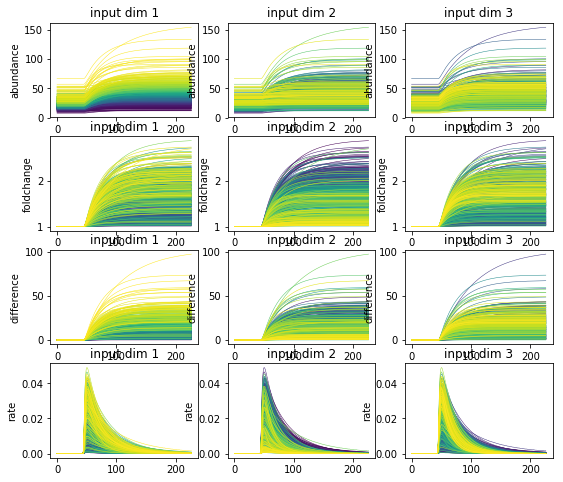

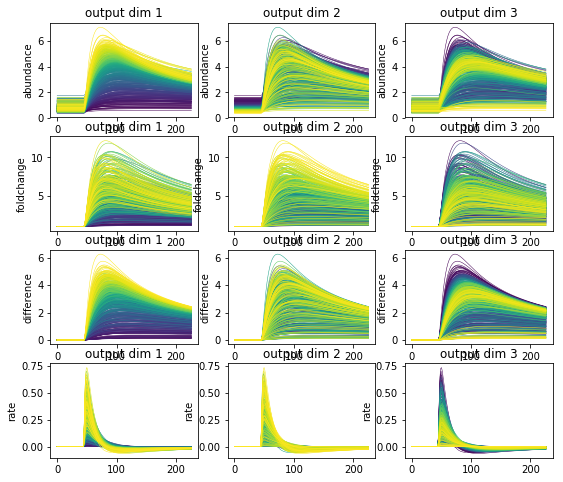

In [71]:
import accessory
importlib.reload(accessory)
# from accessory import plot_trajectories_based_on_dparam
# importlib.reload(accessory)
# from accessory import *
# ev_in = [1,4,11]
# ev_out = [1,7,11]

print(evecs_out.shape)
print('ev_in',ev_in)
print('ev_out',ev_out)
plot_trajectories_based_on_dparam(time_data,ogdin,evecs_in,ev_in,'input')
plot_trajectories_based_on_dparam(time_data,ogdout,evecs_out,ev_out,'output')

# plot_trajectories_based_on_dparam(tvec,traj,evecs_0,ev_0,strstr):
print('done')
# evecs_out[]

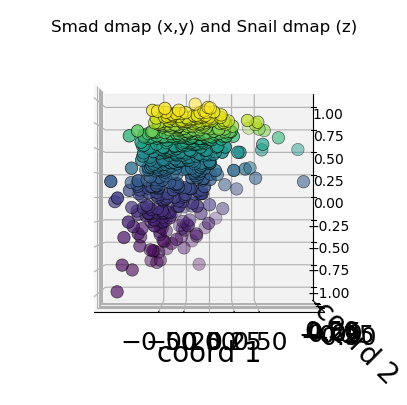

/Users/frick/Dparams/DParamsFinal_v5/2d-manifold_expSYST1_PC/ snailC 3d man.png
done


In [72]:
savepath = str(cwd) + '/2d-manifold_' +conditionid+cond2+'/'
if not os.path.exists(savepath):
    os.makedirs(savepath)
    
fontsize=20
plt.style.use('default')
# plt.style.use('ggplot')   
fsize = (5,5)
msize = 80
lw = 0.5
cmap = plt.cm.viridis

fig = plt.figure(figsize=fsize)
ax = fig.add_subplot(111, projection='3d')
x = evecs_in[:,ev_in[0]].copy()
y = evecs_in[:,ev_in[1]].copy()
cc = evecs_out[:,ev_out[0]].copy()
z = cc.copy()
csort = np.argsort(cc)
cc = range(len(csort))
# cw = np.where(cc>0)
# cc[cw]=0
# csort = range(len(cc))
xx = x[csort]
yy = y[csort]
zz = z[csort]

xtickvec = np.linspace(-1,1,5)
ax.scatter(xx,yy,zz,c=cc,s=msize,edgecolor='k',linewidths=lw, cmap = cmap)
plt.xlabel('coord 1',fontsize=fontsize)
plt.ylabel('coord 2',fontsize=fontsize)
plt.xticks(np.divide(xtickvec,2),fontsize=fontsize-2)
plt.yticks(np.divide(xtickvec,2),fontsize=fontsize-2)
plt.title('Smad dmap (x,y) and Snail dmap (z)')
savestr = savepath+' snailC 3d man.png'
plt.savefig(savestr,bbox_inches='tight')
ax.view_init(0,-90)
plt.show()

print(savestr)
print('done')

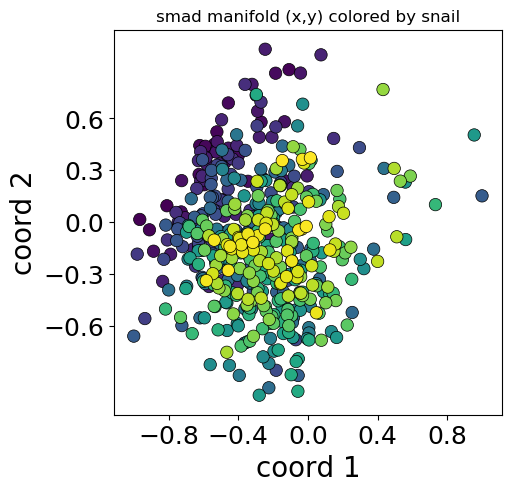

/Users/frick/Dparams/DParamsFinal_v5/2d-manifold_expSYST1_PC/ smad manifold colored by snail.png
done


In [73]:

fig = plt.figure(figsize=fsize)
ax = fig.add_subplot(111)


ax.scatter(xx,yy,c=cc,s=msize,edgecolor='k',linewidths=lw, cmap = cmap)
plt.xlabel('coord 1',fontsize=fontsize)
plt.ylabel('coord 2',fontsize=fontsize)
plt.title('smad manifold (x,y) colored by snail')

xtickvec= np.linspace(-1.6,1.6,5)
plt.xticks(np.divide(xtickvec,2),fontsize=fontsize-2)
xtickvec= np.linspace(-1.2,1.2,5)
plt.yticks(np.divide(xtickvec,2),fontsize=fontsize-2)
savestr = savepath+' smad manifold colored by snail.png'
plt.savefig(savestr,bbox_inches='tight')

plt.show()

print(savestr)
print('done')

In [79]:
def uniqueDMAPStoplot(ev_test):
    import itertools
    icl = list(itertools.combinations(ev_test,2))
    outv = [np.where(~np.in1d(ev_test, x))[0][0] for x in icl]
    plotzys = [list(np.hstack((icl[x],ev_test[outv[x]]))) for x in range(len(icl))]
    return(plotzys)




def plotDMAP(evecs_test,ev_test0,c_vec,fontsize,lw,msize,fsize,cmap,smadsnail):


    
    if len(ev_test0)>2:
        udmap = uniqueDMAPStoplot(ev_test0)
    else:
        udmap = [ev_test0]
    
    wspaceA = 0.7
    fsize[0]=(fsize[0]+wspaceA)*len(udmap)
    fig = plt.figure(figsize=fsize)
    for i in range(len(udmap)):
        ev_test = udmap[i]

        xlabelstr = 'coord 1'
        ylabelstr = 'coord 2'
        titlestr = smadsnail +' manifold'
        if len(ev_test)==1:
            x = np.asarray(range(evecs_test.shape[1])).reshape(-1,)
            y = evecs_test[:,ev_test[0]].copy()
            y = np.sort(y)
            x = np.argsort(y)

            cc = np.zeros(y.shape)
            csort = range(0,len(cc))

            xlabelstr = 'cell index'
            ylabelstr = 'coord 1'

        elif len(ev_test)==2:
            x = evecs_test[:,ev_test[0]].copy()
            y = evecs_test[:,ev_test[1]].copy()

            cc = np.zeros(y.shape)
            csort = range(0,len(cc))

        elif len(ev_test)==3:
            x = evecs_test[:,ev_test[0]].copy()
            y = evecs_test[:,ev_test[1]].copy()
            cc = evecs_test[:,ev_test[2]].copy()
            csort = np.argsort(cc)
            cc = range(len(csort))

            xv = np.where(np.in1d(ev_test0,ev_test[0]))[0][0] +1
            yv = np.where(np.in1d(ev_test0,ev_test[1]))[0][0] +1
            zv = np.where(np.in1d(ev_test0,ev_test[2]))[0][0] +1
            xlabelstr = 'coord '+str(xv)
            ylabelstr = 'coord '+str(yv)
            titlestr = smadsnail +' manifold colored by coord '+str(zv)

        elif len(ev_test)>4:
            error('i break')

        xx = x[csort]
        yy = y[csort]

        
        ax = fig.add_subplot(1,len(udmap),i+1)
        ax.scatter(xx,yy,c=cc,s=msize,edgecolor='k',linewidths=lw, cmap = cmap)
        plt.xlabel(xlabelstr,fontsize=fontsize)
        plt.ylabel(ylabelstr,fontsize=fontsize)
        plt.title(titlestr,fontsize=fontsize)
        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

    fig.subplots_adjust(wspace=wspaceA)
    savestr = savepath+' Snail manifold colored by snail EXTRA.png'
    plt.savefig(savestr,bbox_inches='tight')
    plt.show()

    print(savestr)
    print('done')
    

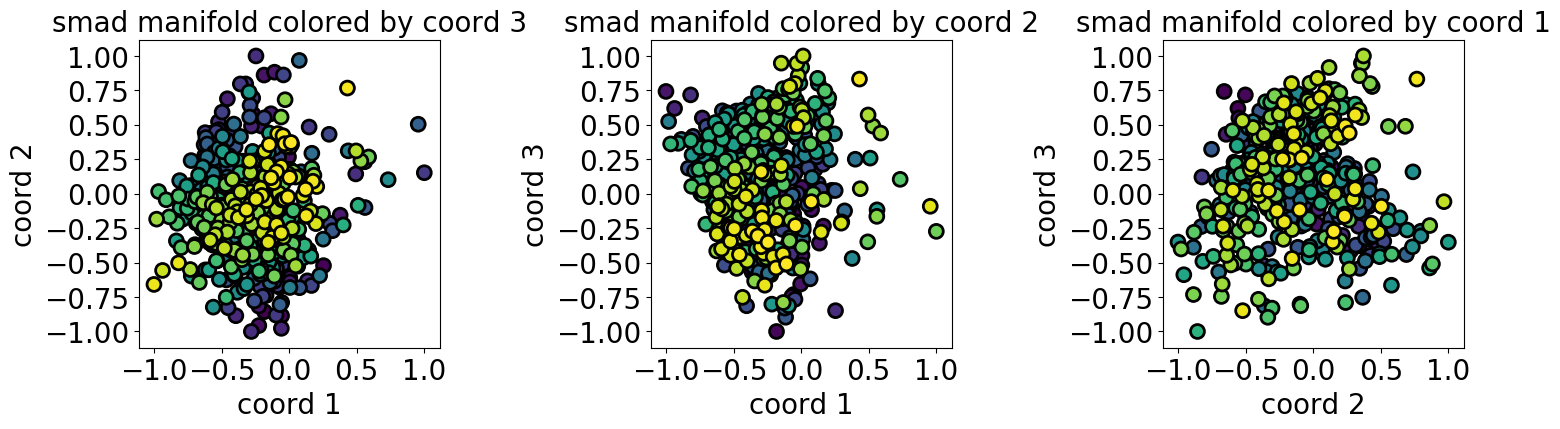

/Users/frick/Dparams/DParamsFinal_v5/2d-manifold_expSYST1_PC/ Snail manifold colored by snail EXTRA.png
done


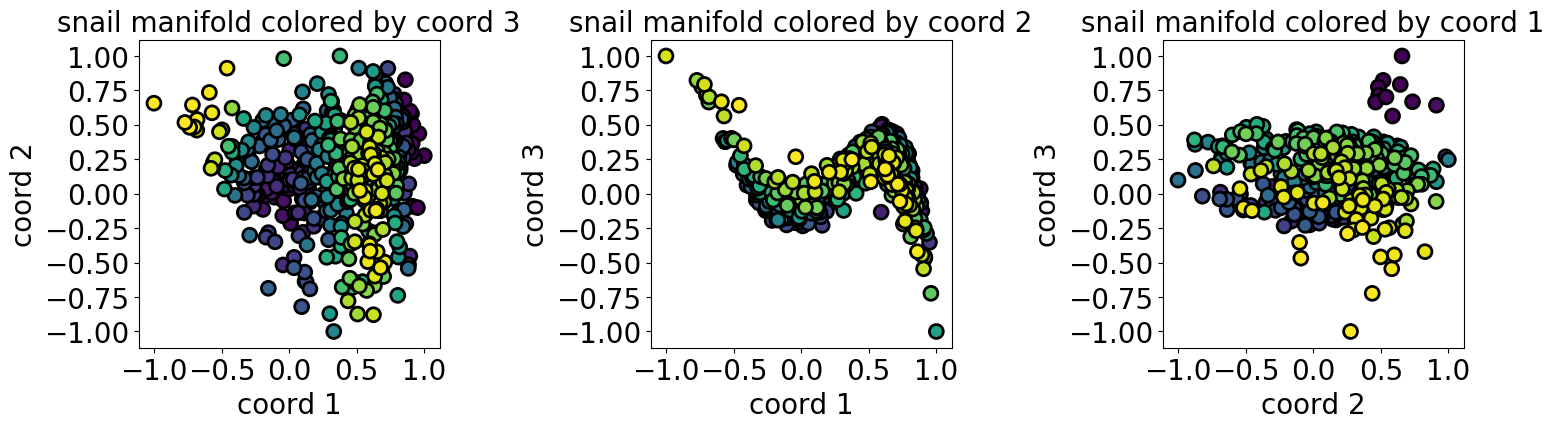

/Users/frick/Dparams/DParamsFinal_v5/2d-manifold_expSYST1_PC/ Snail manifold colored by snail EXTRA.png
done


In [81]:
fsize=[5,4]
msize = 100
lw=2
cmap = plt.cm.viridis
fontsize= 20
evecs_test = evecs_in.copy()
ev_test = ev_in.copy()
c_vec  = np.zeros(evecs_in.shape[0])
smadsnail = 'smad'
plotDMAP(evecs_test,ev_test,c_vec,fontsize,lw,msize,fsize,cmap,smadsnail)

fsize=[5,4]
evecs_test = evecs_out.copy()
ev_test = ev_out.copy()
c_vec  = np.zeros(evecs_out.shape[0])
smadsnail = 'snail'
plotDMAP(evecs_test,ev_test,c_vec,fontsize,lw,msize,fsize,cmap,smadsnail)

In [93]:

def plotDMAPcoloredwithOtherDMAPz(evecs_test,ev_test0,c_vec,cv_in,fontsize,lw,msize,fsize,cmap,ss1,ss2):

    import itertools
    eicl = list(itertools.combinations(ev_test0,2))
    cicl = list(itertools.combinations(cv_in,1))

    
    
    wspaceA = 0.5
    hspaceA = 0.5
    fsize[0]=(fsize[0]+wspaceA)*len(eicl)
    fsize[1]=(fsize[1]+hspaceA)*len(cicl)
    fig = plt.figure(figsize=fsize)
    cycle = iter(range(len(eicl)*len(cicl)))
    for i in range(len(eicl)):
        for j in range(len(cicl)):
            ev_test = eicl[i]


            xlabelstr = 'coord 1'
            ylabelstr = 'coord 2'
            titlestr = ss1 +' manifold'
            if len(ev_test)==1:
                x = np.asarray(range(evecs_test.shape[1])).reshape(-1,)
                y = evecs_test[:,ev_test[0]].copy()
                y = np.sort(y)
                x = np.argsort(y)

                cc = np.zeros(y.shape)
                csort = range(0,len(cc))

                xlabelstr = 'cell index'
                ylabelstr = 'coord 1'

            elif len(ev_test)==2:
                x = evecs_test[:,ev_test[0]].copy()
                y = evecs_test[:,ev_test[1]].copy()
                z = c_vec[:,cv_in[j]].copy()
                cc = z
                csort = range(0,len(cc))
                csort = np.argsort(cc)
                cc = range(len(csort))

                
                xv = np.where(np.in1d(ev_test0,ev_test[0]))[0][0] +1
                yv = np.where(np.in1d(ev_test0,ev_test[1]))[0][0] +1
                zv = j +1
                xlabelstr = ss1+ ' coord '+str(xv)
                ylabelstr = ss1+ ' coord '+str(yv)
                titlestr = ss1 +' manifold colored by '+ ss2 +' coord '+str(zv)
                

            elif len(ev_test)>4:
                error('i break')




            xx = x[csort]
            yy = y[csort]

            cy = next(cycle)
            ax = fig.add_subplot(len(cicl),len(eicl),cy+1)
            ax.scatter(xx,yy,c=cc,s=msize,edgecolor='k',linewidths=lw, cmap = cmap)
            plt.xlabel(xlabelstr,fontsize=fontsize)
            plt.ylabel(ylabelstr,fontsize=fontsize)
            plt.title(titlestr,fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.yticks(fontsize=fontsize)

            fig.subplots_adjust(wspace=wspaceA, hspace=hspaceA)
        
    plt.show()
    
   
    

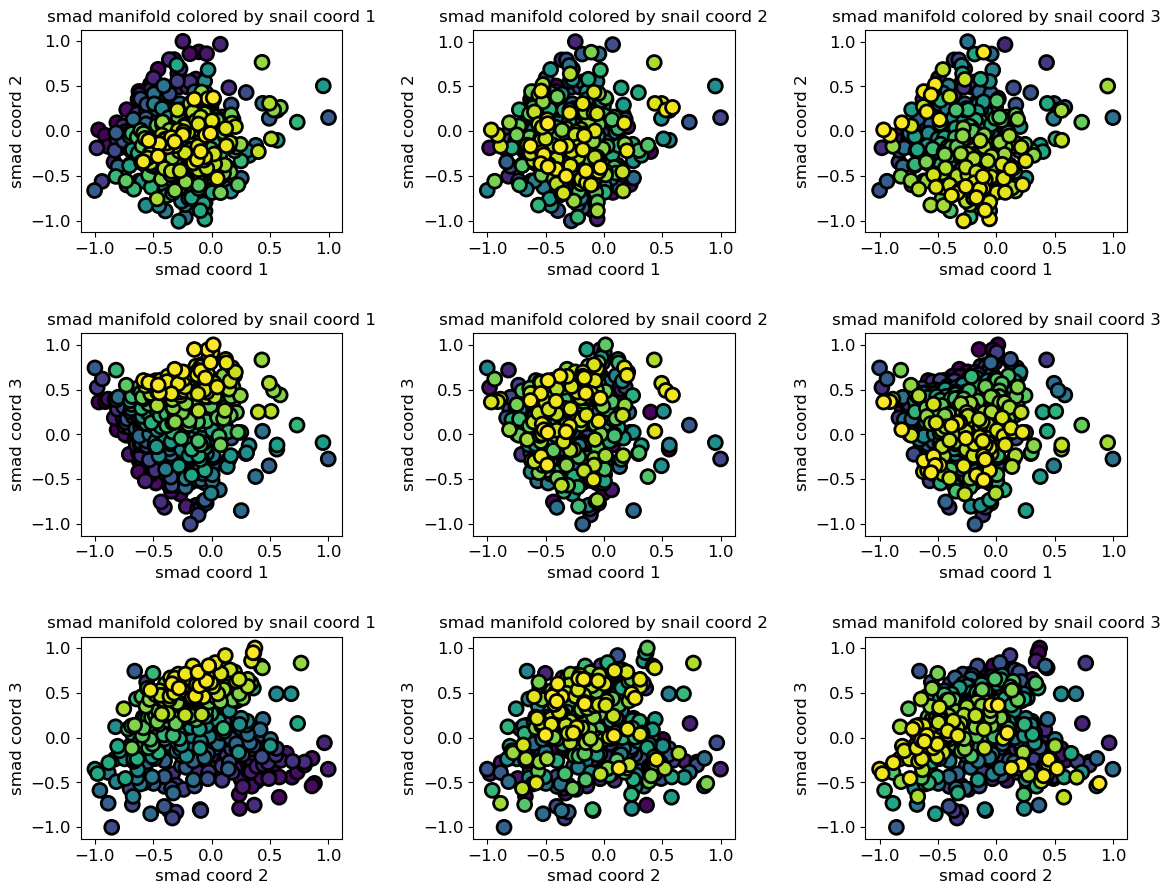

In [95]:
fsize=[4,3]
msize = 100
lw=2
cmap = plt.cm.viridis
fontsize= 12
evecs_test = evecs_in.copy()
ev_test = ev_in.copy()
c_vec  = evecs_out.copy()
cv_in = ev_out.copy()
ss1 = 'smad'
ss2 = 'snail'
plotDMAPcoloredwithOtherDMAPz(evecs_test,ev_test,c_vec,cv_in,fontsize,lw,msize,fsize,cmap,ss1,ss2)

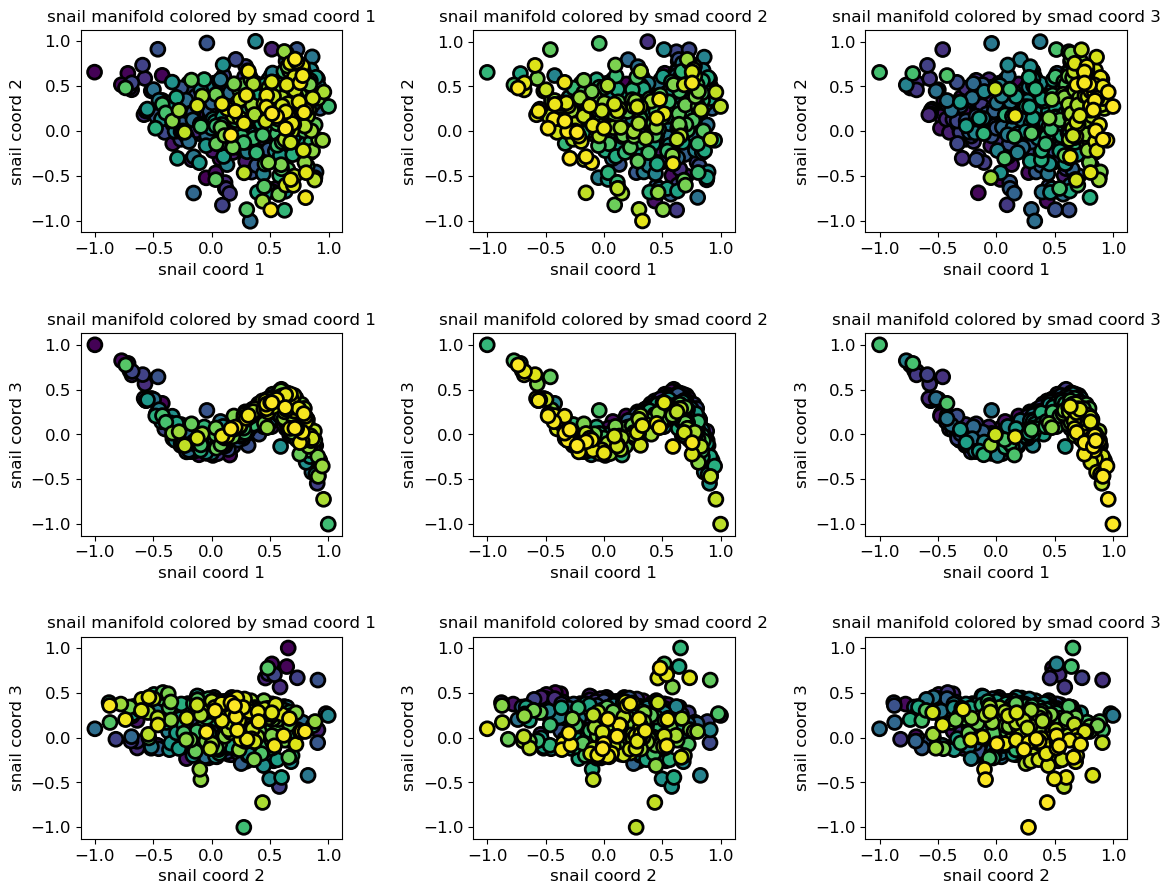

In [96]:
fsize=[4,3]
msize = 100
lw=2
cmap = plt.cm.viridis
fontsize= 12
evecs_test = evecs_out.copy()
ev_test = ev_out.copy()
c_vec  = evecs_in.copy()
cv_in = ev_in.copy()
ss1 = 'snail'
ss2 = 'smad'
plotDMAPcoloredwithOtherDMAPz(evecs_test,ev_test,c_vec,cv_in,fontsize,lw,msize,fsize,cmap,ss1,ss2)

In [ ]:
import dill as pickle;
from pathlib import Path
# import os

# cwd = Path().resolve()
# print(cwd)
# repo = str(cwd) +'/'

session_savepath = 'session' + conditionid + specidpath + 'clean/'
session_path = repo + session_savepath

print(not (os.path.isdir(session_path)))
if not (os.path.isdir(session_path)):
    print('making' + session_path + '...')
    os.mkdir(session_path)

session_name = 'seshy'
savename = session_path + session_name

pickle.dump_session(savename)
print(savename)
print('pickle success!!!')

In [ ]:
# import dill as pickle;
# from pathlib import Path

# # cwd = Path().resolve()
# # print(cwd)
# # repo = str(cwd) +'/'

# session_savepath = 'session' + conditionid + specid + 'clean/'
# session_path = repo + session_savepath
# session_name = 'sesh'
# savename = session_path + session_name


# pickle.load_session(savename)
# print(ev_in)

# first attempt to use the original DMAPS [1,3] and [1] using GPy

In [ ]:
# ev_in = [1,3]
# ev_out = [1]

In [ ]:
print(ev_in)
print(ev_out)

In [97]:
def msefunc(xp,Y):
    mseeach={}
    Yscale = np.zeros(Y.shape)
    xpscale = np.zeros(Y.shape)
    for i in range(0,Y.shape[1]):
        Yscale[:,i] = (Y[:,i]-np.mean(Y[:,i]))/np.std(Y[:,i])
        xpscale[:,i] = (xp[:,i]-np.mean(xp[:,i]))/np.std(xp[:,i])
        mseeach[i]=np.mean((Yscale[:,i]-xpscale[:,i])**2)
    scalex = xpscale
    scaley = Yscale
    mse = np.mean((Yscale-xpscale)**2)
    return scalex,scaley, mse, mseeach

In [98]:
import GPy
#use Smad Manifold to predicut Smad trajectories (1 timepoint)

# sample inputs and outputs
X = evecs_in[:,ev_in]
if len(ev_in)==1:
    X = evecs_in[:,ev_in].reshape(-1,1)


Y = ogdin[:,10].reshape(-1,1) #reshape to look like a 2d input
print(Y.shape)
kerndim = X.shape[1]
ker = GPy.kern.Matern52(kerndim,ARD=True) + GPy.kern.White(kerndim)

# create simple GP model
m = GPy.models.GPRegression(X,Y,ker)

# optimize and plot
m.optimize(messages=True,max_f_eval = 1000)

(500, 1)


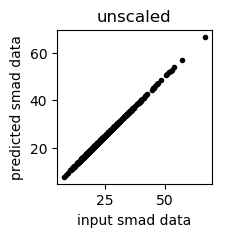

mse =  4.521289862077627e-06


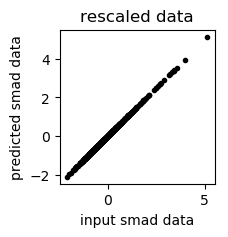

rescaled mse =  4.521091680837477e-06
{0: 4.521091680837477e-06}


In [99]:
#can we predict input data well?
xp,xstd = m.predict(X)
# print(xp)

x1 = Y
y1= xp

fig = plt.figure(figsize=(2,2))
plt.scatter(x1,y1,c='k',marker='.')
plt.xlabel('input smad data')
plt.ylabel('predicted smad data')
plt.title('unscaled')
plt.show()
#mse is deviation from identity
mse = np.mean(((x1/np.std(x1))-(y1/np.std(y1)))**2)
print('mse = ',mse.copy())

x1,y1, mse, mseeach = msefunc(xp,Y)


fig = plt.figure(figsize=(2,2))
plt.scatter(x1,y1,c='k',marker='.')
plt.xlabel('input smad data')
plt.ylabel('predicted smad data')
plt.title('rescaled data')
plt.show()
print('rescaled mse = ',mse)
print(mseeach.copy())


In [100]:
def Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr):
    kerndim = X.shape[1]
    ker = GPy.kern.Matern52(kerndim,ARD=True) + GPy.kern.White(kerndim)

    # create simple GP model
    m = GPy.models.GPRegression(X,Y,ker)

    # optimize and plot
    m.optimize(messages=messages,max_f_eval = max_f_eval)
    return m
    
def Gpy_mse_plot(m,X,Y,inputstr,outputstr):
    xp,xstd = m.predict(X)
    x1,y1, mse, mseeach = msefunc(xp,Y)
    msev = np.asarray(list(mseeach.values())).reshape(-1,)
    x1s = x1.shape[1]
    ws = 1
    fig = plt.figure(figsize=((4 + (ws*(x1s-1)))*x1s,4))
    for i in range(0,x1.shape[1]):
        x = x1[:,i]
        y = y1[:,i]
        if x1.shape[1]==1:
            plt.scatter(x,y,c='k',marker='.')
            plt.xlabel('orig.' + outputstr)
            plt.ylabel('pred.' + outputstr)
        else:
            ax = fig.add_subplot(1,x1s,i+1)
            ax.scatter(x,y,c='k',marker='.')
            plt.xlabel('orig.' + outputstr)
            plt.ylabel('pred.' + outputstr)
        if x1.shape[1]>1:
            plt.title('predict ' + outputstr + ' dim-' + str(i+1) + ' based on ' + inputstr)
        else:
            plt.title('predict ' + outputstr + ' based on ' + inputstr)
        ax = plt.gca()
        t = ax.text(0.01,0.99,'rescaled mse = ',transform=ax.transAxes, horizontalalignment='left',verticalalignment='top')
        t = ax.text(0.01,0.95,str(np.round(msev[i],5)),transform=ax.transAxes, horizontalalignment='left',verticalalignment='top')
    plt.show()
    return mseeach

In [101]:
def predSpecificBasedOnDMAP(time_data,ss1,ss2,X,X2,sdat1,sdat2):
    msekeeper={}
    import GPy
    #use Smad Manifold to predicut Smad trajectories (1 timepoint)
    # sample inputs and outputs
    max_f_eval = 1000
    messages=False
    inputstr = ss1 + ' dmaps'
    tvec = time_data[1,:]
    basal = ((np.where(tvec<=0))[0])
    peak = ((np.where(tvec<=30))[0])[-1]

    X=X0.copy()
    outputstr = ss1 + ' tpoint'
    Y = sdat1[:,10].reshape(-1,1) #reshape to look like a 2d input
#     Y = sdat1[:,[5,10,15]]
    m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)
    mseeach = Gpy_mse_plot(m,X,Y,inputstr,outputstr)
    msekeeper[outputstr]=mseeach

    X=X0.copy()
    outputstr = ss1 + ' max relative rate'
    
    rate=np.zeros(sdat1.shape[0])
    for j in range(sdat1.shape[0]):
        rate[j] = np.max(sdat1[j,:]/np.median(sdat1[j,basal]))

    Y = rate.reshape(-1,1) #reshape to look like a 2d input
    m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)
    mseeach = Gpy_mse_plot(m,X,Y,inputstr,outputstr)
    msekeeper[outputstr]=mseeach


    X=X0.copy()
    outputstr = ss1 + ' maximum integral'
    rate=np.zeros(sdat1.shape[0])
    for j in range(sdat1.shape[0]):
        rate[j] = np.max(np.cumsum(sdat1[j,:]))

    Y = rate.reshape(-1,1) #reshape to look like a 2d input
    m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)
    mseeach = Gpy_mse_plot(m,X,Y,inputstr,outputstr)
    msekeeper[outputstr]=mseeach


    X=X0.copy()
    outputstr = ss1 + ' foldchange at tpeak'
    foldchange = sdat1[:,peak]/np.median(sdat1[:,basal])
    Y = foldchange.reshape(-1,1) #reshape to look like a 2d input
    m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)
    mseeach = Gpy_mse_plot(m,X,Y,inputstr,outputstr)
    msekeeper[outputstr]=mseeach

    X = X0.copy()
    outputstr = ss1 + ' difference at tpeak'
    foldchange = sdat1[:,peak]-np.median(sdat1[:,basal])
    Y = foldchange.reshape(-1,1) #reshape to look like a 2d input
    m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)
    mseeach = Gpy_mse_plot(m,X,Y,inputstr,outputstr)
    msekeeper[outputstr]=mseeach


    X=X0.copy()
    outputstr = ss2 + ' difference'
    snaildiff = sdat2[:,peak]-np.median(sdat2[:,basal])
    Y = snaildiff.reshape(-1,1) #reshape to look like a 2d input
    m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)
    mseeach = Gpy_mse_plot(m,X,Y,inputstr,outputstr)
    msekeeper[outputstr]=mseeach

    X=X0.copy()
    outputstr = ss2 + ' dmap'
    Y = X2.copy()
    m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)
    mseeach = Gpy_mse_plot(m,X,Y,inputstr,outputstr)
    msekeeper[outputstr]=mseeach
    
    for v in range(X.shape[1]):
        print(v)
#         outputstr = ss2 + ' dmap, using ' +ss1+ ' ' +str(list(range(1,v+2)))
        inputstr0 = ss1 + ' ' + str(list(range(1,v+2)))
        print(inputstr0)
        X=X0.copy()
        Y = X2.copy()
        m = Gpymadness(X[:,0:v+1],Y,messages,max_f_eval,inputstr0,outputstr)
        mseeach = Gpy_mse_plot(m,X,Y,inputstr0,outputstr)
        msekeeper[outputstr]=mseeach
        
    return msekeeper


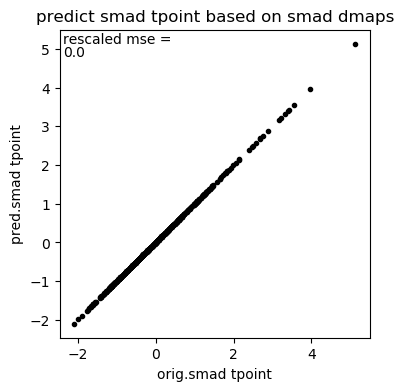

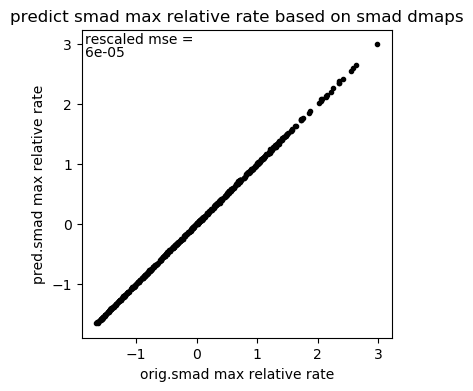

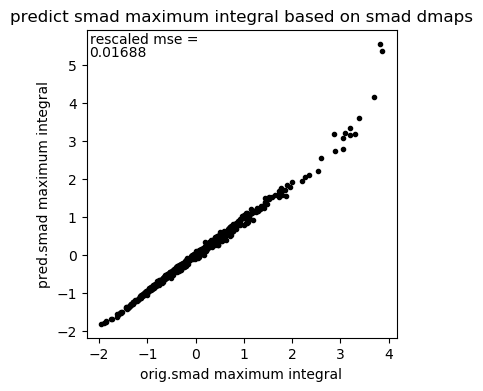

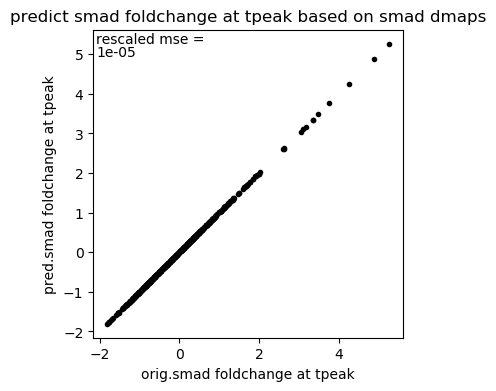

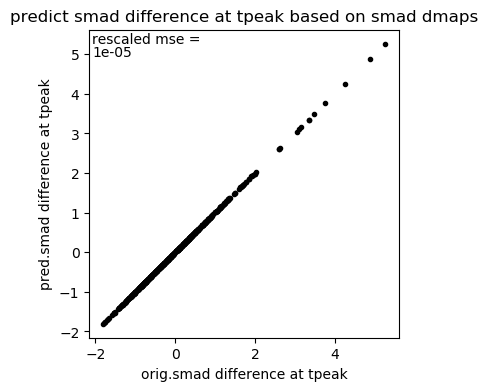

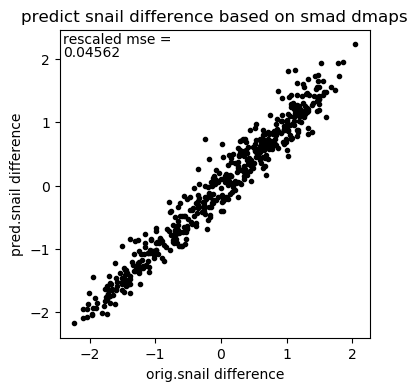

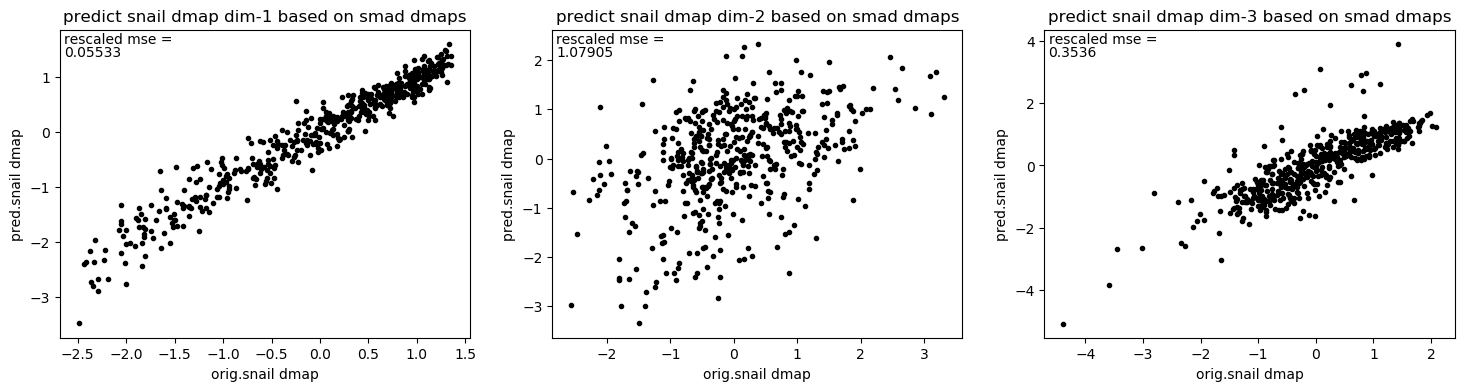

0
smad [1]


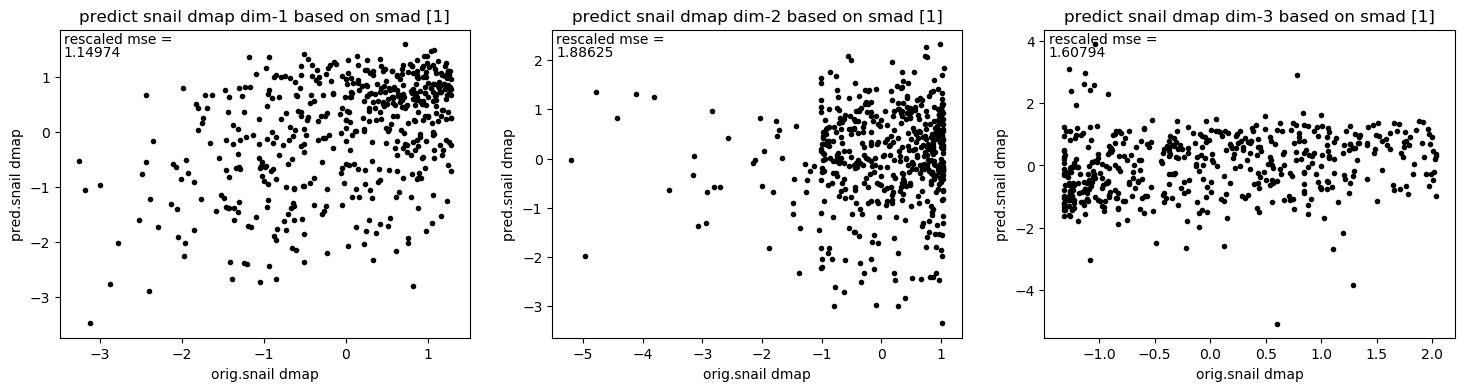

1
smad [1, 2]


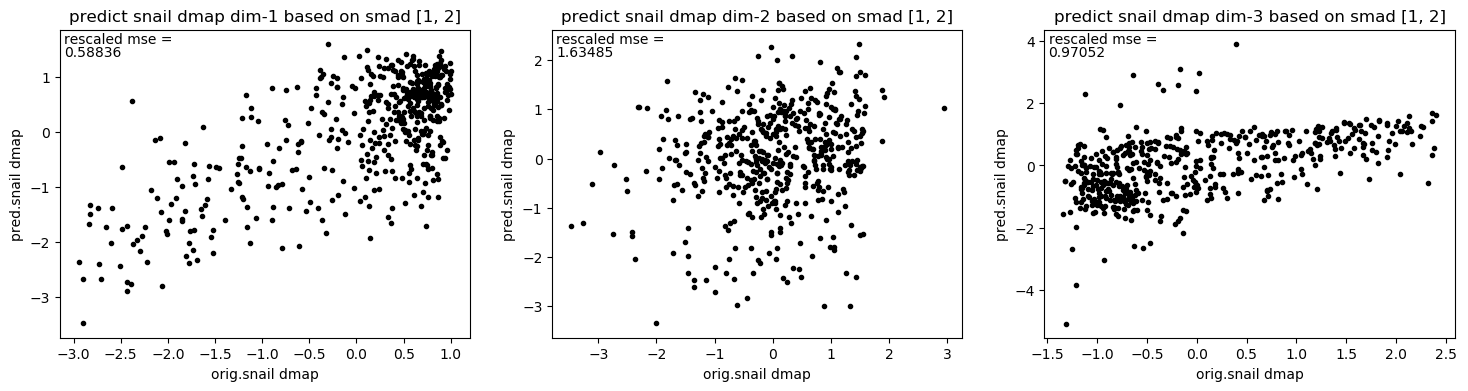

2
smad [1, 2, 3]


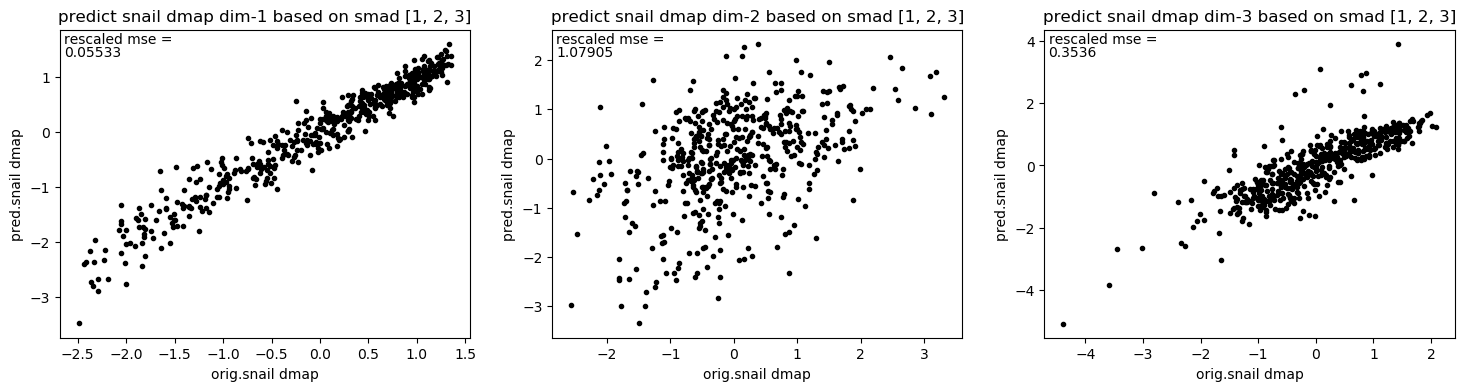

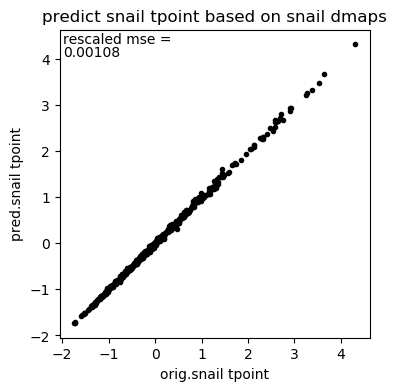

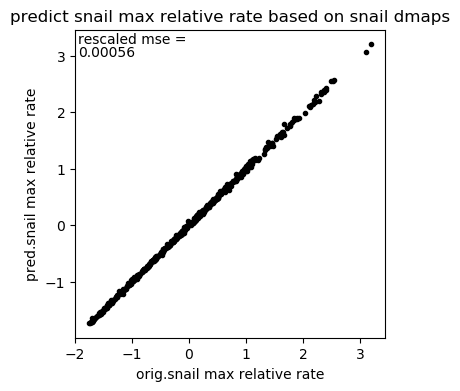

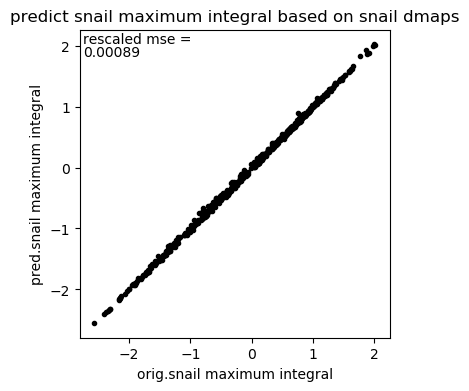

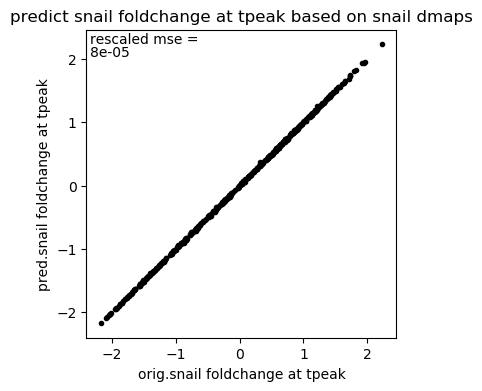

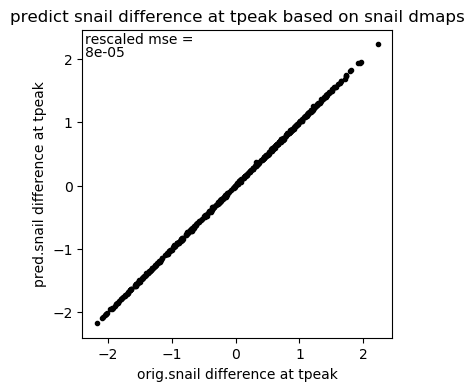

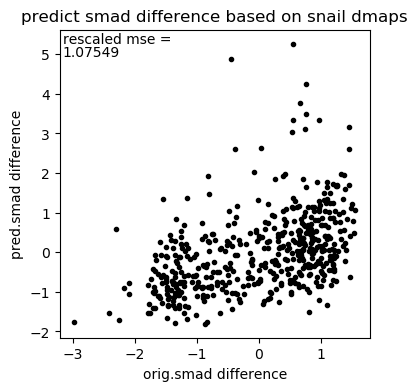

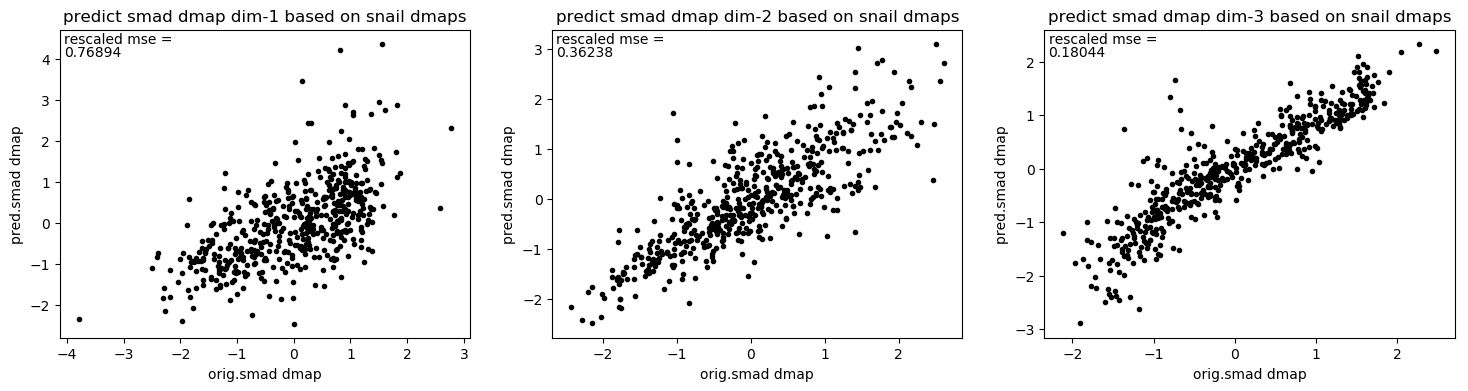

0
snail [1]


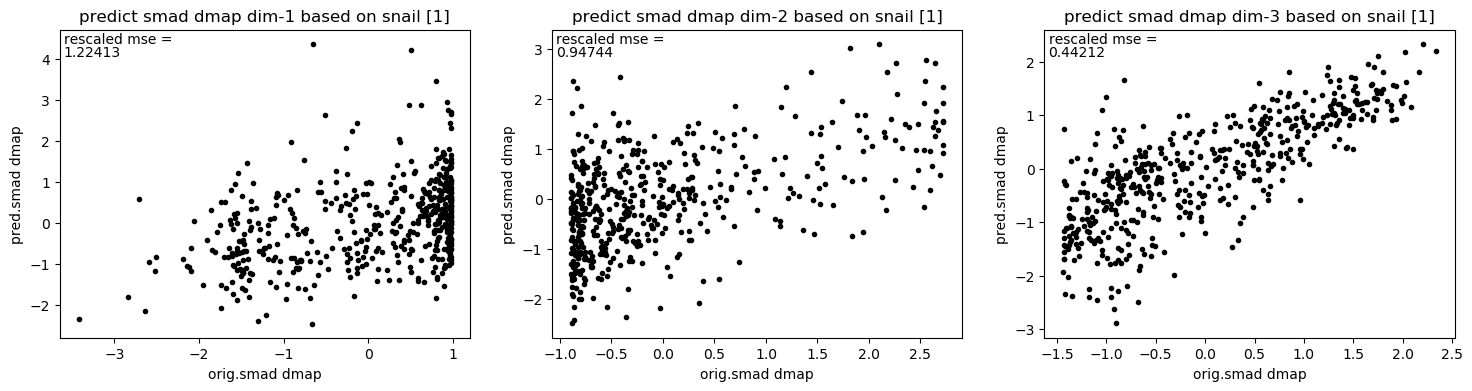

1
snail [1, 2]


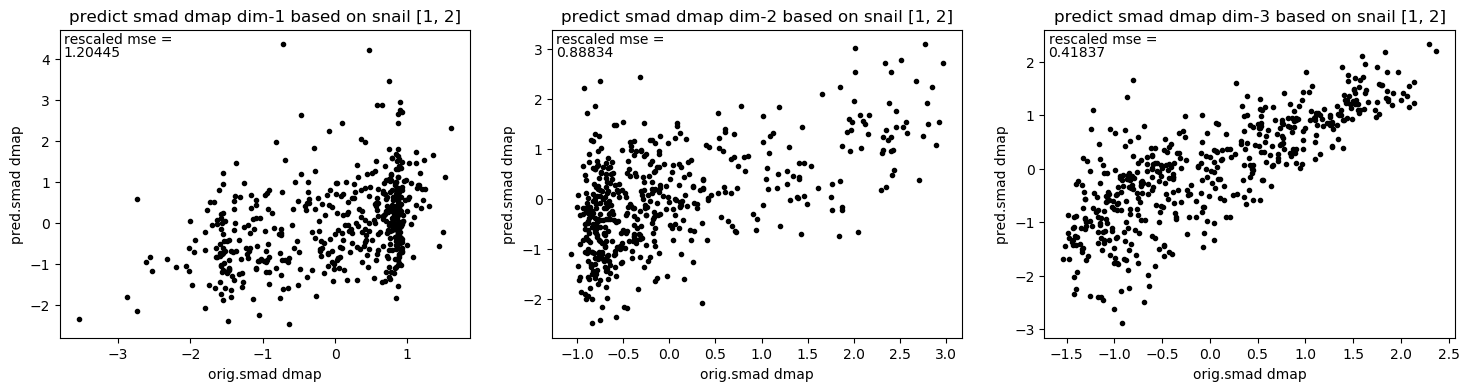

2
snail [1, 2, 3]


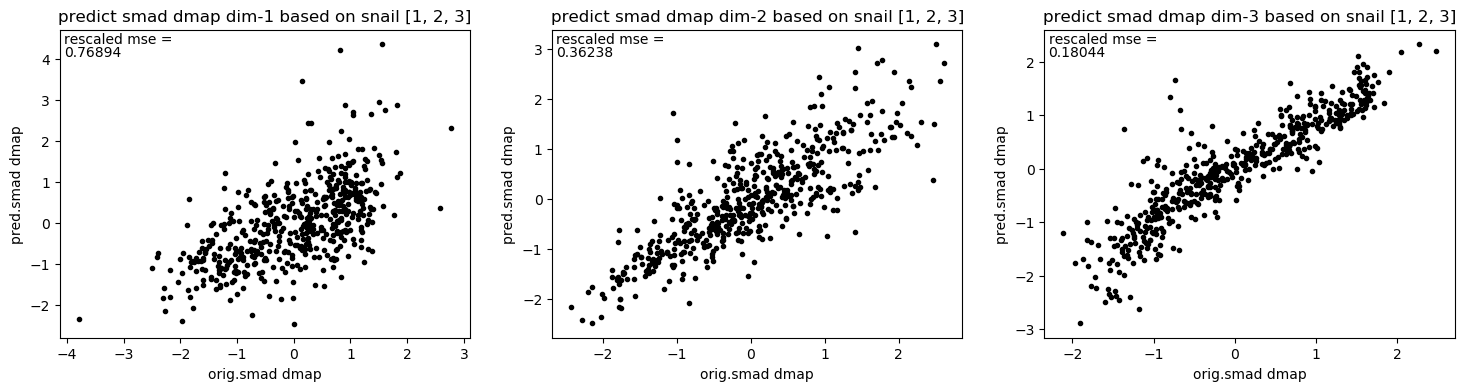

In [102]:
#predictions based on Smad
ss1 = 'smad'
ss2 = 'snail'
X = evecs_in[:,ev_in].copy()
X0=X.copy()
sdat1 = ogdin.copy()
sdat2 = ogdout.copy()
X2 = evecs_out[:,ev_out].copy()
msekeepersmad = predSpecificBasedOnDMAP(time_data,ss1,ss2,X,X2,sdat1,sdat2)

ss1 = 'snail'
ss2 = 'smad'
X = evecs_out[:,ev_out].copy()
X0=X.copy()
sdat1 = ogdout.copy()
sdat2 = ogdin.copy()
X2 = evecs_in[:,ev_in].copy()
msekeepersnail = predSpecificBasedOnDMAP(time_data,ss1,ss2,X,X2,sdat1,sdat2)

In [103]:
def Gpy_eachtpoint(X,Yin0,samp_vec,messages,max_f_eval,inputstr,outputstr):
    Yin = Yin0[:,samp_vec]
    msearray = np.zeros(Yin.shape[1])
    for j in range(0,Yin.shape[1]):
        Y = Yin[:,j].reshape(-1,1)

        max_f_eval = 1000
        messages=False
        m = Gpymadness(X,Y,messages,max_f_eval,inputstr,outputstr)

        xp,xstd = m.predict(X)
        x = Y
        y = xp
        x1,y1, mse, mseeach = msefunc(xp,Y)
        msearray[j]=mse
        print(j, end=" " )
    print('completed' + inputstr + outputstr)
    return msearray


In [104]:


time_vec = time_data[1,:]
tsample = 3
tsamp = np.min([tsample,len(time_vec)])

print(len(time_vec))

axfact = 5

ax1 = np.ceil(len(time_vec)/2) - np.ceil(len(time_vec)/5)
ax2 = np.ceil(len(time_vec)/2) + np.ceil(len(time_vec)/5)
samp_vec = np.linspace(ax1,ax2,tsamp,dtype='int32')
print(samp_vec)
print(time_vec[samp_vec])


227
[ 68 114 160]
[15.5556 45.9462 76.338 ]


In [105]:
def make_samp_vec(Yin):
    ltv = Yin.shape[1]
    ax1 = np.ceil(ltv/2) - np.ceil(ltv/5)
    ax2 = np.ceil(ltv/2) + np.ceil(ltv/5)
    samp_vec = np.linspace(ax1,ax2,tsamp,dtype='int32')
    return samp_vec

In [106]:

def gpy_each_timepoint(inputstr,X,fsmad,fsmadpro,snaildat,ss1,ss2):
    #attempt to predict input data at all timepoints using Smad Dmaps
    msecombo={} #initialize the master msecombo
    max_f_eval = 1000
    messages = False

    ## run each
    outputstr = ss1 + ' at each tpoint'
    Yin = fsmad
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray


    outputstr = ss2 + ' at each tpoint'
    Yin = snaildat
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray


    outputstr = 'f('+ss1+')'
    Z = fsmad.copy()
    mu, sigma = 0, 0.0 # mean and standard deviation
    for j in range(0,fsmad.shape[1]):
        s = np.random.normal(mu, sigma, fsmad.shape[0])
        Z[:,j] = (fsmad[:,j]**2) + s

    Yin = removeAllzerotpoints(Z.copy())
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray

    
    outputstr = 'f('+ss1+')+smallnoise'
    Z = fsmad.copy()
    mu, sigma = 0, 0.01 # mean and standard deviation
    for j in range(0,fsmad.shape[1]):
        s = np.random.normal(mu, sigma, fsmad.shape[0])
    #     s = np.random.lognormal(mean, sigma, size=fsmad.shape[0])
        Z[:,j] = (fsmad[:,j]**2) + s

    Yin = removeAllzerotpoints(Z.copy())
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray

    
    outputstr = 'f('+ss1+')+mediumnoise'
    Z = fsmad.copy()
    mu, sigma = 0, 0.1 # mean and standard deviation
    for j in range(0,fsmad.shape[1]):
        s = np.random.normal(mu, sigma, fsmad.shape[0])
        Z[:,j] = (fsmad[:,j]**2) + s

    Yin = removeAllzerotpoints(Z.copy())
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray
    
    
    outputstr = 'f('+ss1+'_processed)'
    Z = fsmadpro.copy()
    mu, sigma = 0, 0.0 # mean and standard deviation
    for j in range(0,fsmadpro.shape[1]):
        s = np.random.normal(mu, sigma, fsmadpro.shape[0])
        Z[:,j] = (fsmadpro[:,j]**2) + s

    Yin = removeAllzerotpoints(Z.copy())
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray
    
    outputstr = 'f('+ss1+'_processed)+s_noise'
    Z = fsmadpro.copy()
    mu, sigma = 0, 0.01 # mean and standard deviation
    for j in range(0,fsmadpro.shape[1]):
        s = np.random.normal(mu, sigma, fsmadpro.shape[0])
        Z[:,j] = (fsmadpro[:,j]**2) + s

    Yin = removeAllzerotpoints(Z.copy())
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray
    
    outputstr = 'f('+ss1+'_processed)+m_noise'
    Z = fsmadpro.copy()
    mu, sigma = 0, 0.1 # mean and standard deviation
    for j in range(0,fsmadpro.shape[1]):
        s = np.random.normal(mu, sigma, fsmadpro.shape[0])
        Z[:,j] = (fsmadpro[:,j]**2) + s


    Yin = removeAllzerotpoints(Z.copy())
    samp_vec = make_samp_vec(Yin)
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray


    outputstr = 'noise only'
    Z = fsmad.copy()
    samp_vec = make_samp_vec(Yin)
    mu, sigma = 0, 1 # mean and standard deviation
    for j in range(0,fsmad.shape[1]):
        s = np.random.normal(mu, sigma, fsmad.shape[0])
        Z[:,j] = s

    Yin = Z
    msearray = Gpy_eachtpoint(X,Yin,samp_vec,messages,max_f_eval,inputstr,outputstr)
    msecombo[outputstr] = msearray
    return msecombo

In [107]:
# msecombosmad = msecombo.copy()
inputstr = 'smad dmap'
X = evecs_in[:,ev_in].copy()
fsmad = reducedimensionalityforGPy(ogdin.copy())
fsmadpro = reducedimensionalityforGPy(observed_data_in.copy())
snaildat = reducedimensionalityforGPy(ogdout.copy())
ss1 = 'smad'
ss2 = 'snail'
msecombosmad = gpy_each_timepoint(inputstr,X,fsmad,fsmadpro,snaildat,ss1,ss2)


TypeError: reducedimensionalityforGPy() missing 1 required positional argument: 'reducedimval'

In [ ]:
inputstr = 'snail dmap'
X = evecs_out[:,ev_in].copy()
fsmad = reducedimensionalityforGPy(ogdout.copy())
fsmadpro = reducedimensionalityforGPy(observed_data_out.copy())
snaildat = reducedimensionalityforGPy(ogdin.copy())
ss1 = 'snail'
ss2 = 'smad'
msecombosnail = gpy_each_timepoint(inputstr,X,fsmad,fsmadpro,snaildat,ss1,ss2)


In [ ]:
def msecomboplotter(tvec,msecombo,smadsnail,yl):
    plt.figure(figsize=(5,3))
    subkeep={}
    cycle=0
    for k in msecombo.keys():
        cycle=cycle+1
        v = msecombo[k]
      # k is now the key
      # v is the value
        subkeep[k]=v
        plt.semilogy(tvec+(cycle/100),v,'*-', label=k)
        
    plt.ylim(yl[0],yl[1])
    plt.ylabel('mean square error')
    plt.xlabel('time point, value')
    plt.title('error for different predictions based on '+ smadsnail + ' manifold') 
    plt.legend()
    plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))
    plt.show()
        
def msecombomedianplotter(msecombo,smadsnail):
    plt.figure(figsize=(6,3))
    msecombo2 = msecombo.copy()
    cycle=-1
    for k in msecombo.keys():
        y={}
        cycle=cycle+1
        v = msecombo[k]
        y[cycle] = np.median(v)
        msecombo2[k] = y

    cycle=-1
    for k in msecombo2.keys():
        cycle=cycle+1
        v = msecombo2[k]
      # k is now the key
      # v is the value
        y = v.values()
        if len(y)==1:
            x = cycle
            markerstr='o'
        else:
            x = np.linspace(cycle-0.1,cycle+0.1,len(y))
            markerstr='*-'
        plt.semilogy(x,y,markerstr, label=k)
        
            # plt.ylim(0.01,1)
    plt.ylabel('mean square error')
    plt.xlabel('attempted prediction')
    plt.title('error for different predictions based on ' + smadsnail + ' manifold') 
    plt.legend(loc='right',bbox_to_anchor=(1.5, 0.5))
    plt.show()
    
    
def msekeeperplotter(msekeeper2,yl,smadsnail):  
    cycle=-1
    plt.figure(figsize=(4,2))
    for k in msekeeper2.keys():
        cycle=cycle+1
        v = msekeeper2[k]
      # k is now the key
      # v is the value
        y = np.asarray(list(v.values())).reshape(-1,)
        if len(y)==1:
            x = cycle
            markerstr='o'
            msize = 7
            if y<yl[0]:
                x = cycle
                markerstr = 'v'
                print('edited value lower than,', yl[0])
                y = yl[0]*2
                msize=7
        else:
            x = np.linspace(cycle-0.1,cycle+0.1,len(y))
            markerstr='*-'
            msize=7
        plt.semilogy(x,y,markerstr, label=k, markersize = msize)

    plt.ylim(yl[0],yl[1])
    plt.ylabel('mean square error')
    plt.xlabel('attempted prediction')
    plt.title('error for different predictions based on ' + smadsnail + ' manifold') 
    plt.legend(loc='right',bbox_to_anchor=(1.8, 0.5))
    plt.show()

In [ ]:
yl = [1e-4,5]
smadsnail='smad'
msekeeperplotter(msekeepersmad,yl,smadsnail)
smadsnail='snail'
msekeeperplotter(msekeepersnail,yl,smadsnail)
   

In [ ]:


samp_vec = make_samp_vec(time_data_in)
tvec = time_data_in[1,:]
smadsnail = 'smad'
msecomboplotter(tvec[samp_vec]/60,msecombosmad,smadsnail,yl)
smadsnail = 'snail'
msecomboplotter(tvec[samp_vec]/60,msecombosnail,smadsnail,yl)

In [ ]:
import dill as pickle;
from pathlib import Path
# import os

# cwd = Path().resolve()
# print(cwd)
# repo = str(cwd) +'/'

session_savepath = 'session' + conditionid + specidpath + 'clean/'
session_path = repo + session_savepath

print(not (os.path.isdir(session_path)))
if not (os.path.isdir(session_path)):
    print('making' + session_path + '...')
    os.mkdir(session_path)

session_name = 'seshyAfterGPy'
savename = session_path + session_name

pickle.dump_session(savename)
print(savename)
print('pickle success!!!')